### We show a minimal working example for the three types of scaffold completion described in the article 
### Feel free to modify with a scaffold of your choice if you want to try our scaffold constrained generator!

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit import DataStructs

from scaffold_constrained_model import scaffold_constrained_RNN
from data_structs import Vocabulary, Experience
from utils import Variable, seq_to_smiles, fraction_valid_smiles, unique
from rdkit.Chem.Draw import IPythonConsole

import matplotlib.pyplot as plt
import torch
 
# Loading trained model and appropriate vocabulary

voc = Vocabulary(init_from_file="data/DistributionLearningBenchmark/Voc")
    
Agent = scaffold_constrained_RNN(voc)
print(Agent.rnn.state_dict)
if torch.cuda.is_available():
    Agent.rnn.load_state_dict(torch.load('data/DistributionLearningBenchmark/Prior_ChEMBL_randomized.ckpt'))
else:
    Agent.rnn.load_state_dict(torch.load('data/DistributionLearningBenchmark/Prior_ChEMBL_randomized.ckpt', map_location=lambda storage, loc: storage))


<bound method Module.state_dict of MultiGRU(
  (embedding): Embedding(50, 128)
  (gru_1): GRUCell(128, 512)
  (gru_2): GRUCell(512, 512)
  (gru_3): GRUCell(512, 512)
  (linear): Linear(in_features=512, out_features=50, bias=True)
)>


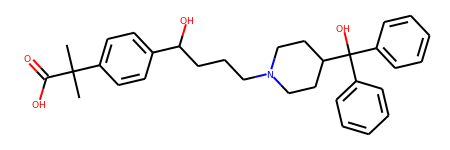

In [2]:
# Fexofenadine
Chem.MolFromSmiles('CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC2)C(O)(c3ccccc3)c4ccccc4')

# 1. Replacing a fragment

/site/rp/work/projects/DD/Jupyter/notebooks/Maxime/scaffold-constrained-generation/scaffold_constrained_model.py:181: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = F.softmax(logits)
/site/rp/work/projects/DD/Jupyter/notebooks/Maxime/scaffold-constrained-generation/scaffold_constrained_model.py:182: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_prob = F.log_softmax(logits)


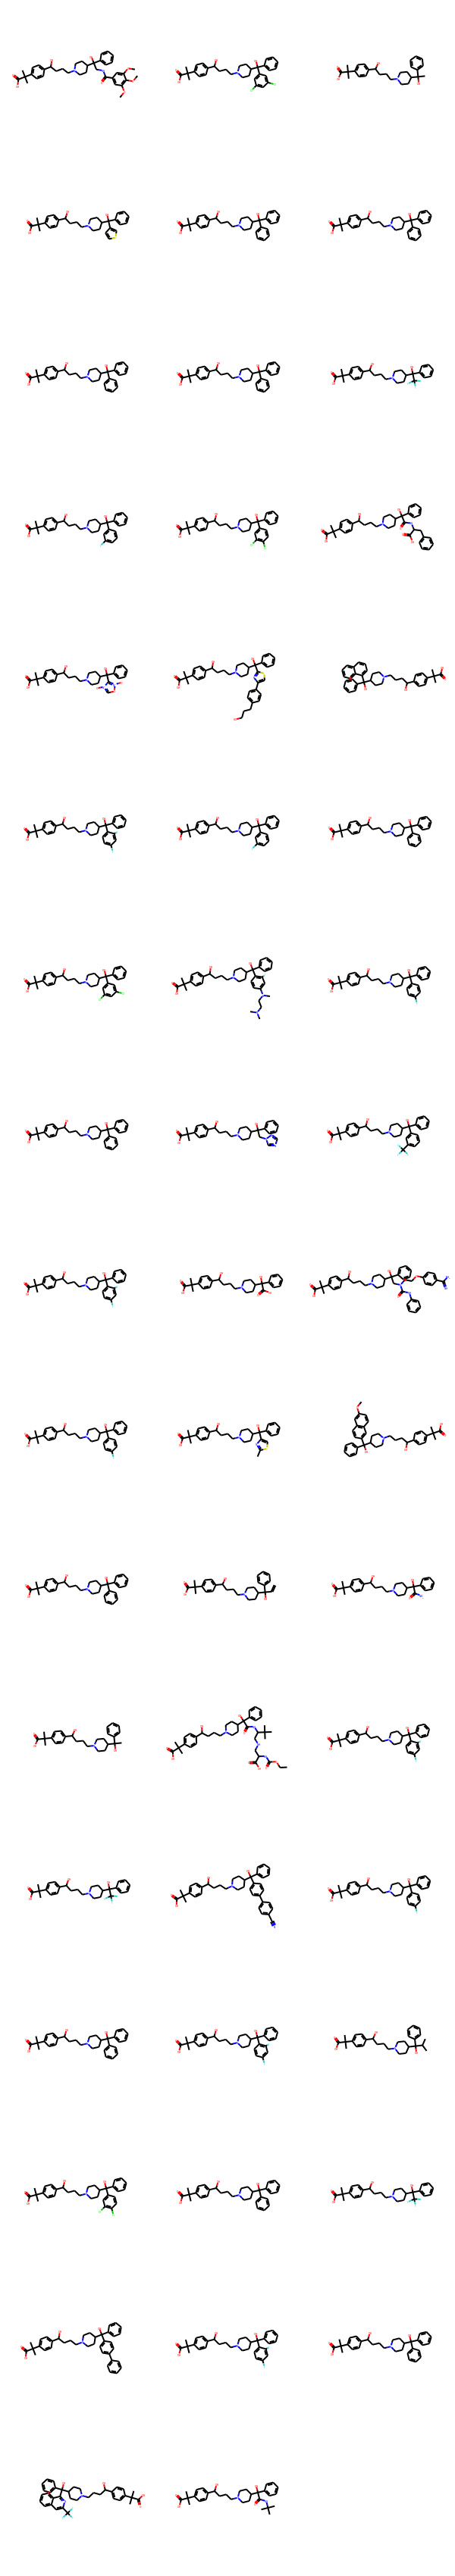

In [3]:
seqs, agent_likelihood, entropy = Agent.sample(pattern='CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC2)C(O)(*)c4ccccc4', batch_size=50)
smiles = seq_to_smiles(seqs, voc)
mols = []
for s in smiles:
    m = Chem.MolFromSmiles(s)
    if m:
        mols.append(m)
Draw.MolsToGridImage(mols)

# 2. Replacing a linker

RDKit ERROR: [22:27:13] non-ring atom 18 marked aromatic
RDKit ERROR: [22:27:13] Can't kekulize mol.  Unkekulized atoms: 20 21 22 25 28
RDKit ERROR: 
RDKit ERROR: [22:27:13] Can't kekulize mol.  Unkekulized atoms: 15 16 18 19 20 21 22 23 24 25 26 27 28
RDKit ERROR: 
RDKit ERROR: [22:27:13] Explicit valence for atom # 33 C, 6, is greater than permitted
RDKit ERROR: [22:27:13] Can't kekulize mol.  Unkekulized atoms: 17 24 26
RDKit ERROR: 


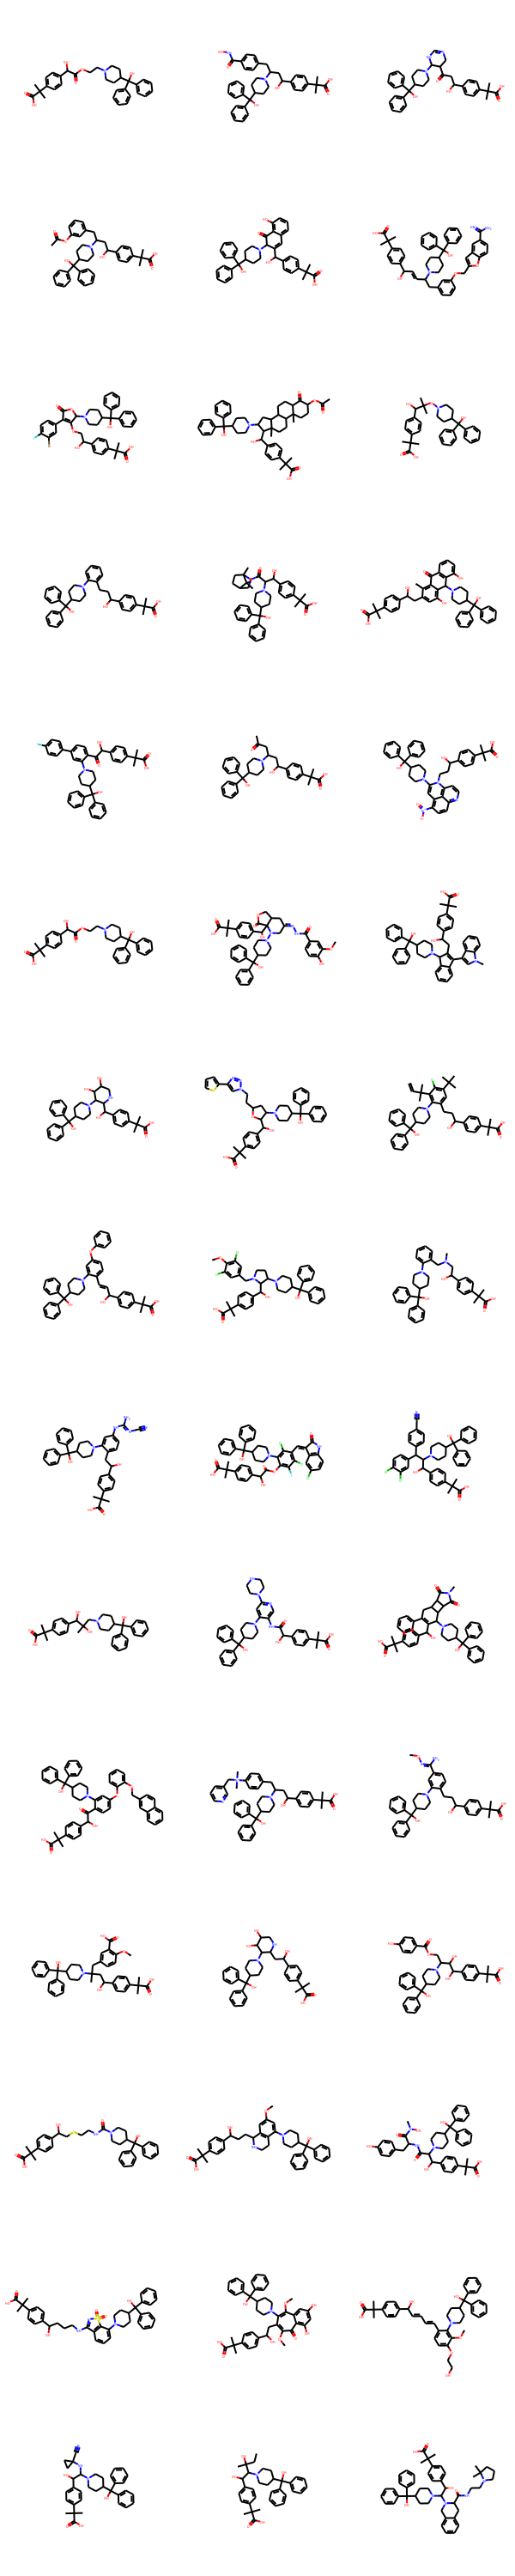

In [4]:
seqs, agent_likelihood, entropy = Agent.sample(pattern='CC(C)(C(=O)O)c1ccc(cc1)C(O)C*N2CCC(CC2)C(O)(c3ccccc3)c4ccccc4', batch_size=50)
smiles = seq_to_smiles(seqs, voc)
mols = []
for s in smiles:
    m = Chem.MolFromSmiles(s)
    if m:
        mols.append(m)
Draw.MolsToGridImage(mols)

# 3. Discrete choices

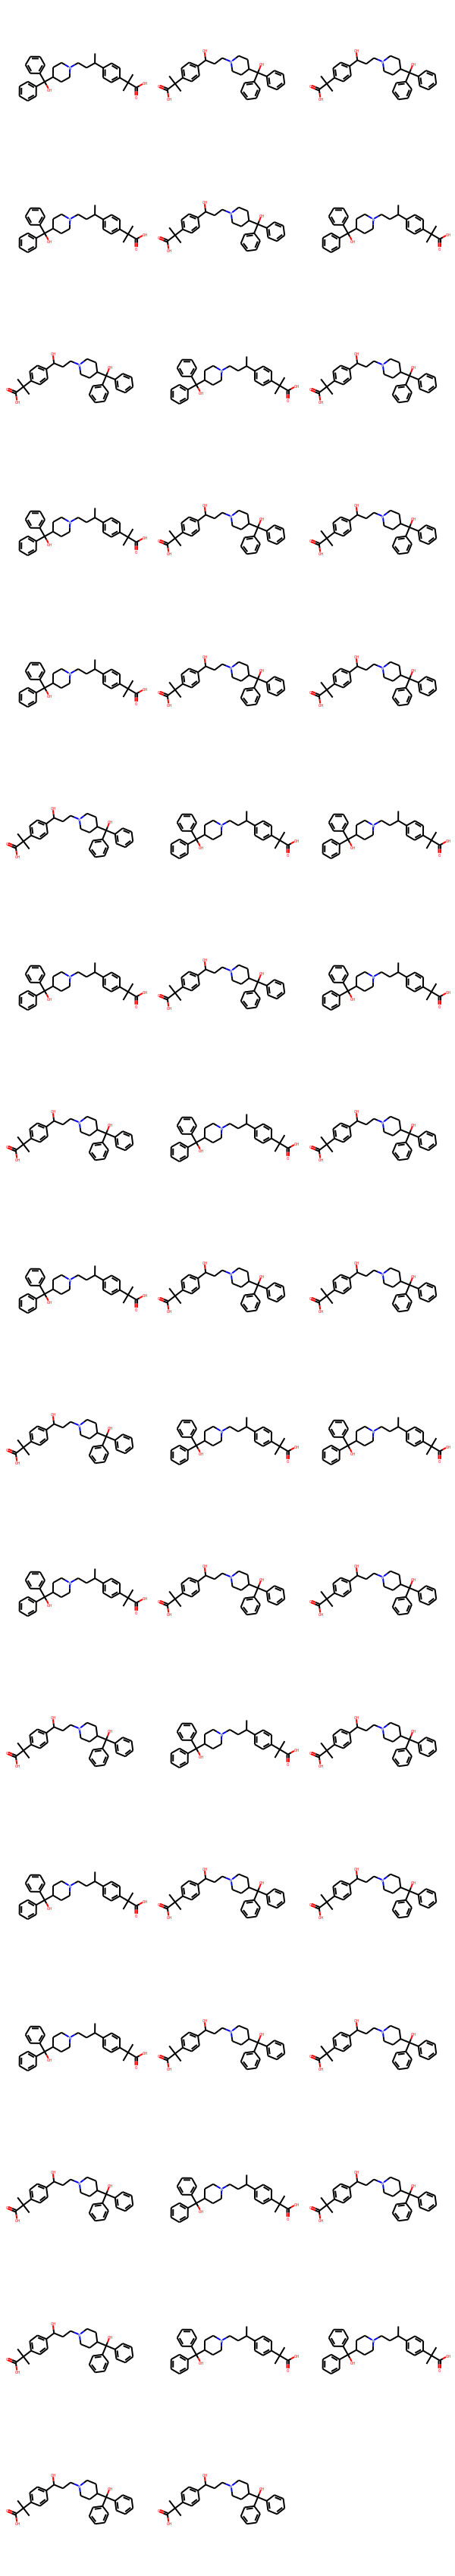

In [5]:
# Let's say we want to choose between putting either an oxygen or a carbon

seqs, agent_likelihood, entropy = Agent.sample(pattern='CC(C)(C(=O)O)c1ccc(cc1)C([O,C])CCN2CCC(CC2)C(O)(c3ccccc3)c4ccccc4', batch_size=50)
smiles = seq_to_smiles(seqs, voc)
mols = []
for s in smiles:
    m = Chem.MolFromSmiles(s)
    if m:
        mols.append(m)
Draw.MolsToGridImage(mols)